<a href="https://colab.research.google.com/github/CMedrado/Topicosemcomputa-o/blob/main/OpenOffice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto no contexto da Predição de Severidade de Bug Reports

Exemplo de classificação de texto com pipeline de NLP e classificador no final

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
# Tokenização
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("english").stem(item))
    return stems

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Carregando os dados
df = pd.read_csv('/content/drive/My Drive/TP/PF/Dataset (1)/OpenOffice_total.csv') # Salvamos com esse nome antes

# Dataset
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,40313,Base,databas wizard button label errorn referenc ge...,start databasewizard click men neue datenbank ...,code,trivial,P4,marc.neumann,berend.cornelius ocke.janssen ocke.janssen ock...,FIXED
1,11539,Base,function sql queri return proper,s imagin tabl databas selector select tabl ret...,code,trivial,P4,marc.neumann,ntf frank.schoenheit ocke.janssen wolframgarte...,FIXED
2,63132,Base,standard view mode toolbar show wrong tip form...,item standard view mode toolbar show hint,code,trivial,P4,marc.neumann,jaschulz frank.schoenheit jaschulz marc.neuman...,FIXED
3,43180,Base,titl form wizard report wizard miss space,mark p extrem trivial fix second work user vis...,code,trivial,P4,marc.neumann,jclift caiot1 jclift frank.schoenheit berend.c...,FIXED
4,21660,Base,queri form lock w bad criteria,queri design form random tabl drop tabl column...,code,trivial,P4,christoph.lukasiak,brian.pellerin brian.pellerin christoph.lukasi...,FIXED
5,70174,Base,chang case column name tabl save,chang case column dbase tabl chang save reprod...,code,trivial,P4,marc.neumann,lists christoph.lukasiak christoph.lukasiak oc...,FIXED
6,44812,Base,form wizard silent form s form,follow instruct issu creat form wizard interes...,code,trivial,P4,marc.neumann,frank.schoenheit berend.cornelius berend.corne...,FIXED
7,30607,Base,cw insight assert interfacecontainer cxx start...,creat databas click queri icon choos wizard cr...,code,trivial,P4,marc.neumann,christoph.lukasiak ocke.janssen ocke.janssen b...,FIXED
8,86043,Base,mdb file openoffice org base program disappear,report discuss openoffice org http www openoff...,code,trivial,P4,marc.neumann,aloboaleu drewjensen.inbox christoph.lukasiak ...,FIXED
9,50660,Base,base ca creat relationship compound joint key,appear issu interfac creat relationship tabl b...,code,trivial,P4,marc.neumann,andrew andrew andrew marc.neumann frank.schoen...,FIXED


In [7]:
df['severity_level'].value_counts()

trivial     21731
normal        924
major         555
critical      177
blocker        57
minor          37
Name: severity_level, dtype: int64

In [8]:
class_names = df['severity_level'].unique()
class_names

array(['trivial', 'normal', 'blocker', 'critical', 'minor', 'major'],
      dtype=object)

In [9]:
status_names = df['status'].unique() 
status_names

array(['FIXED'], dtype=object)

In [10]:
#Convertendo 'summary' e 'description' para string
df = df.astype({'summary':'str', 'description':'str'})

In [11]:
#Filtrando severidades confiaveis
df = df.loc[(df['severity_level'] != 'enhancement') & (df['severity_level'] != 'normal')]

In [14]:
#Modificando severidade diferente de blocker (Classificação binaria)
df.loc[(df['severity_level'] != 'blocker'), 'severity_level'] = "no-blocker"

In [15]:
df['severity_level'].value_counts()

no-blocker    22500
blocker          57
Name: severity_level, dtype: int64

In [16]:
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,40313,Base,databas wizard button label errorn referenc ge...,start databasewizard click men neue datenbank ...,code,no-blocker,P4,marc.neumann,berend.cornelius ocke.janssen ocke.janssen ock...,FIXED
1,11539,Base,function sql queri return proper,s imagin tabl databas selector select tabl ret...,code,no-blocker,P4,marc.neumann,ntf frank.schoenheit ocke.janssen wolframgarte...,FIXED
2,63132,Base,standard view mode toolbar show wrong tip form...,item standard view mode toolbar show hint,code,no-blocker,P4,marc.neumann,jaschulz frank.schoenheit jaschulz marc.neuman...,FIXED
3,43180,Base,titl form wizard report wizard miss space,mark p extrem trivial fix second work user vis...,code,no-blocker,P4,marc.neumann,jclift caiot1 jclift frank.schoenheit berend.c...,FIXED
4,21660,Base,queri form lock w bad criteria,queri design form random tabl drop tabl column...,code,no-blocker,P4,christoph.lukasiak,brian.pellerin brian.pellerin christoph.lukasi...,FIXED
5,70174,Base,chang case column name tabl save,chang case column dbase tabl chang save reprod...,code,no-blocker,P4,marc.neumann,lists christoph.lukasiak christoph.lukasiak oc...,FIXED
6,44812,Base,form wizard silent form s form,follow instruct issu creat form wizard interes...,code,no-blocker,P4,marc.neumann,frank.schoenheit berend.cornelius berend.corne...,FIXED
7,30607,Base,cw insight assert interfacecontainer cxx start...,creat databas click queri icon choos wizard cr...,code,no-blocker,P4,marc.neumann,christoph.lukasiak ocke.janssen ocke.janssen b...,FIXED
8,86043,Base,mdb file openoffice org base program disappear,report discuss openoffice org http www openoff...,code,no-blocker,P4,marc.neumann,aloboaleu drewjensen.inbox christoph.lukasiak ...,FIXED
9,50660,Base,base ca creat relationship compound joint key,appear issu interfac creat relationship tabl b...,code,no-blocker,P4,marc.neumann,andrew andrew andrew marc.neumann frank.schoen...,FIXED


In [17]:
df.shape[0]

22557

In [18]:
# Stop Words

nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,1))),
                # Classificador
                ('clf',   KNeighborsClassifier(n_jobs=-5)),
            ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Divididos em 11 quadros não sobrepostos de tamanhos iguais.

In [19]:
df_set = []
k = 2050
for i in range(0,10):
  df_set.append(df.iloc[i*2050:k])
  k += 2050
  print("Quadro {}".format(i), "possui {} entradas.".format(df_set[i].shape[0]))

df_set.append(df.iloc[20500:22557])

print("Quadro 10 possui {} entradas.".format(df_set[10].shape[0]))

Quadro 0 possui 2050 entradas.
Quadro 1 possui 2050 entradas.
Quadro 2 possui 2050 entradas.
Quadro 3 possui 2050 entradas.
Quadro 4 possui 2050 entradas.
Quadro 5 possui 2050 entradas.
Quadro 6 possui 2050 entradas.
Quadro 7 possui 2050 entradas.
Quadro 8 possui 2050 entradas.
Quadro 9 possui 2050 entradas.
Quadro 10 possui 2057 entradas.


In [20]:
X_test = []

for i in range(0, 10):
  new_df = df_set[0]
  for j in range(0, i):
    new_df = pd.merge(new_df, df_set[j+1], how = 'outer')
  X_test.append(new_df)

In [21]:
for i in range(0, len(X_test)):
  print("Treinamento {}, possui {} entradas.". format(i+1, X_test[i].shape[0]))

Treinamento 1, possui 2050 entradas.
Treinamento 2, possui 4100 entradas.
Treinamento 3, possui 6150 entradas.
Treinamento 4, possui 8200 entradas.
Treinamento 5, possui 10250 entradas.
Treinamento 6, possui 12300 entradas.
Treinamento 7, possui 14350 entradas.
Treinamento 8, possui 16400 entradas.
Treinamento 9, possui 18450 entradas.
Treinamento 10, possui 20500 entradas.


In [22]:
# Evaluate
for i in range(0, len(X_test)):
  text_clf = text_clf.fit(X_test[i].description, X_test[i].assignee_developers)
  pred = text_clf.predict(df_set[i+1].description)
  accuracy_scoreMLP_TFIDF = f1_score(df_set[i+1].assignee_developers, pred, average='micro')
  accuracy_scoreMLP_TFIDF

In [23]:

predictions = text_clf.predict(df_set[10].description)

conf_matrix = confusion_matrix(df_set[10].assignee_developers, predictions)

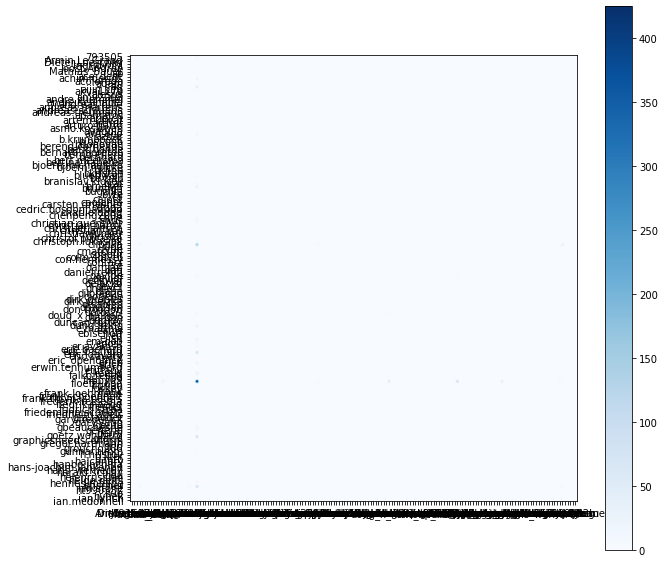

In [24]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()